# Tension modulated string

This notebook contains an implementation of the tension modulated string model. Based on this paper[^1] and the code included with this paper[^2].

[^1]: Trautmann, L, and R. Rabenstein. "Sound synthesis with tension modulated nonlinearities based on functional transformations"
[^2]: J. Parker, S. Schlecht, M. Schäfer, and R. Rabenstein, “Physical Modeling Using Recurrent Neural Networks with Fast Convolutional Layers”


In [ ]:
# | default_exp solver.wave1d_tenmod

### Step 1: 

Start with the non-linear tension modulated string model. The model is defined by the following equations:

$$
\begin{align}
\rho A \frac{\partial^2 y}{\partial t^2} + EI \frac{\partial^4 y}{\partial x^4} - T_{NL}(y) \frac{\partial^2 y}{\partial x^2} + d_{1} \frac{\partial y}{\partial t} + d_{3} \frac{\partial^3 y}{\partial t^3} = f(x,t)
\end{align}
$$

where $T_{NL}$ is the non-linear tension function truncated at the third order:

$$
\begin{aligned}
T_{N L}(y) & =T_0+T_1(y(x, t)) \\
& =T_0+\frac{E A}{2 l_0} \int_0^{l_0} y^2(x, t) d x .
\end{aligned}
$$


### Step 2:

Perform a transformation of the PDE with respect to the spatial variable $x$. We can do this using the transformation kernel $K(x, \beta_{\mu})$.

$$
\begin{aligned}
K\left(x, \beta_\mu\right) & =\sin \left(\frac{\mu \pi}{l_0} x\right) \\
\beta_\mu^4 & =E I\left(\frac{\mu \pi}{l_0}\right)^4+T_0\left(\frac{\mu \pi}{l_0}\right)^2
\end{aligned}
$$

where $\beta_\mu$ is the frequency variable. We see that the $K(x, \beta_{\mu})$ is a function that generates the fourier sine series of the spatial variable $x$.

The spatial tranformation of the non-linear term $T_{1}$ is given as:

$$
\mathcal{T}\left\{T_1\right\} = \bar{b}(\mu,y,\bar{y})
$$

We now can write the transformed PDE as:

$$
\boxed{
\begin{aligned}
\rho A \ddot{\bar{y}}(\mu, t) + \left(d_3 \eta_\mu^2+d_1\right) \dot{\bar{y}}(\mu, t) + \beta_\mu^4 \bar{y}(\mu, t)-\bar{b}(\mu, y, \bar{y}) = 0
\end{aligned}
}
$$

Where $\eta_\mu=-\left(\mu \pi / l_0\right)^2$. The initial conditions are given as:

$$
\begin{aligned}
\bar{y}_0(\mu) &= \mathcal{T}{\left\{y_0(x)\right\}} \\
\dot{\bar{y}}_0(\mu) &= \mathcal{T}{\left\{\dot{y}_0(x)\right\}} = 0
\end{aligned}
$$


### Step 3:

Discretize the non-linear term $\bar{b}(\mu, y, \bar{y})$


$$
\begin{aligned}
\bar{b}^d(\mu) & =\eta_\mu^2 \frac{E A \bar{y}(\mu)}{2 l_0} \int_0^{l_0}\left[\sum_{\nu=1}^M \frac{1}{N_\nu} \bar{y}^d(\nu) K(\xi, \nu)\right]^{\prime 2} d x \\
& =\eta_\mu^2 \frac{E A \pi^2 \bar{y}(\mu)}{l_0^4} \sum_{\nu=1}^M \nu^2\left(\bar{y}^d(\nu)\right)^2
\end{aligned}
$$

### Step 4 

Write as a system of first order ODEs:

$$
\begin{aligned}
\dot{\bar{y}}(\mu, t) &= \bar{v}(\mu, t) \\
\dot{\bar{v}}(\mu, t) &= \frac{-\left(d_3 \eta_\mu^2+d_1\right)}{\rho A} \bar{v}(\mu, t) - \frac{\beta_\mu^4}{\rho A} \bar{y}(\mu, t) + \frac{\bar{b}(\mu, y, \bar{y})}{\rho A}
\end{aligned}
$$

This is a system of first-order ODEs. In matrix form, we can write this as:

$$
\boxed{
\begin{aligned}
\mathbf{\dot{\bar{y}}} &= \mathbf{\bar{v}} \\
\mathbf{\dot{\bar{v}}} &= -\mathbf{M_v} \mathbf{\bar{v}} - \mathbf{M_y} \mathbf{\bar{y}} + \mathbf{\bar{b}}
\end{aligned}
}
$$

The Matrices $\mathbf{M_v}$, $\mathbf{M_y}$ are diagonal matrices whose order is equal to the number of modes $M$.

$$
\begin{aligned}
\mathbf{M_v} &= \text{diag}\left(\frac{d_3 \eta_\mu^2+d_1}{\rho A}\right) \\
\mathbf{M_y} &= \text{diag}\left(\frac{\beta_\mu^4}{\rho A}\right)
\end{aligned}
$$

The vector $\mathbf{b}$ contains the non-linear terms and is given as:



$$
\mathbf{\Eta} = \text{diag}\left(\eta_\mu^2\right) \\
T_{1} = \frac{E A \pi^2}{l_0^4} \mathbf{\bar{y}}(\mu)^T \cdot \Eta \cdot \mathbf{\bar{y}} \\
\mathbf{\bar{b}} = T_{1} \text{diag}(\frac{\eta_\mu^2}{\rho A}) \mathbf{\bar{y}} 
$$


In [ ]:
# | export

import numpy as np
from scipy.integrate import solve_ivp
from physmodjax.utils.ftm import forward_STL, inverse_STL
from numba import jit, njit
from functools import partial
from einops import rearrange

In [ ]:
from matplotlib import pyplot as plt

The parameters of the model are:

- $N$: number of points in the string
- $T$: total time of simulation 
- $f_s$: sampling rate
- $l$: length of string
- $A$: string cross-sectional area
- $E$: Young's modulus
- $I$: string moment of inertia
- $\rho$: density
- $Ts_0$: initial tension
- $d_{1}$: string frequency independent damping
- $d_{3}$: string frequency dependent damping
- $M$: number of modes to include in the modal expansion

In [ ]:
# | export


@njit
def nonlinear_string_func(
    t,  # time
    state,  # state vector
    n_max_modes,  # number of modes
    use_nonlinear,  # use nonlinear wave equation
    pre,  # precalculated constant
    H,  # H matrix
    H_1,  # H_1 matrix
    M_v,  # M_v matrix
    M_y,  # M_y matrix
) -> np.ndarray:  # state at timestep t and position x (u(x, t))
    # unpack the state vector
    y = state[:n_max_modes]  # displacement in modal coordinates
    v = state[n_max_modes:]  # velocity in modal coordinates

    # add axis for calculation
    y = y.reshape(-1, 1)

    # calculate the $\bar{b}$ vector
    if use_nonlinear:
        t_1 = pre * y.T @ H @ y
        b = t_1 * H_1 @ y

    # update the state vector
    v = v
    dv_dt = -M_v @ v - M_y @ y.reshape(-1)

    if use_nonlinear:
        dv_dt -= b.reshape(-1)

    # return the state derivatives
    return np.concatenate((v, dv_dt))


class Wave1dSolverTensionModulated:
    """
    Tension modulated wave equation solver.

    This solver is based on the paper "Sound Synthesis With Tension Modulated Nonlinearities"
    and the accompanying code to the paper "Physical Modeling using Recurrent Neural Networks with Fast Convolutional Layers".
    """

    # fmt: off
    def __init__(
        self,
        sampling_rate: int = 48000,  # 1/s     Temporal sampling frequency
        final_time: float = 0.5,     # s       Duration of the simulation
        n_gridpoints: int = 101,     # pts/m   Spatial sampling grid
        length: float = 1.00,        # m       Length at rest
        A: float = 0.19634e-6,       # m**2    Cross section area
        I: float = 0.02454e-12,      # m**4    Moment of intertia
        rho: float = 7800,           # kg/m**3 Density
        E: int = 190e9,              # Pa      Young's modulus
        d1: float = 4e-3,            # kg/(ms) Frequency independent loss
        d3: float = 6e-5,            # kg m/s  Frequency dependent loss
        Ts0: float = 150,            # N       Tension
        n_max_modes: int = 50,       #         Number of modal expansion terms
        use_nonlinear: bool = True,  #         Use nonlinear wave equation
        method: str = "DOP853",      #         Integration method
        rtol: float = 1e-12,         #         Relative tolerance
        atol: float = 1e-14,         #         Absolute tolerance
    ):
    # fmt: on
        # Attributes intrinsic to the Wave Equation PDE
        self.pde_num_variables = 1
        self.pde_num_spatial_dimensions = 1
        self.pde_order_time_derivatives = 2

        # Attributes of the simulation
        self.sampling_rate = sampling_rate
        self.final_time = final_time
        self.n_gridpoints = n_gridpoints
        self.length = length
        self.use_nonlinear = use_nonlinear
        self.method = method
        self.rtol = rtol
        self.atol = atol
        
        self.A = A
        self.I = I
        self.rho = rho
        self.E = E
        self.d1 = d1
        self.d3 = d3
        self.Ts0 = Ts0

        # For Dirichlet BC, the number of possible modes is equal the the number of points in the interior of the domain
        if n_max_modes > n_gridpoints - 2:
            self.n_max_modes = n_gridpoints - 2
            print(f"n_max_modes too high, setting to {self.n_max_modes}")
        else:
            self.n_max_modes = n_max_modes

        #  spatial grid
        self.grid = np.linspace(0, self.length, self.n_gridpoints)
        self.dx = self.grid[1] - self.grid[0]  # m     spatial sampling interval

        #  temporal grid use arange to make sure that the timestep corresponds exactly to the sampling frequency
        self.dt = 1 / self.sampling_rate  # s     temporal sampling interval
        self.timesteps = np.arange(0, self.final_time, self.dt)

        self.mu = np.ascontiguousarray(np.arange(1, self.n_max_modes + 1, dtype=np.float64))
        self.wavenumbers = self.mu * np.pi / self.length

        self.modes = np.sin(np.outer(self.wavenumbers, self.grid))

        # precalculate the variables
        eta_mu = self.wavenumbers
        beta_mu = self.E * self.I * eta_mu**4 + self.Ts0 * eta_mu**2

        # calculate the matrices        
        self.H = np.ascontiguousarray(np.diag(self.mu**2))
        self.H_1 = np.ascontiguousarray(np.diag(eta_mu**2)) / (rho * A)
        self.M_v = np.ascontiguousarray(np.diag(d1 + d3 * eta_mu**2)) / (rho * A)
        self.M_y = np.ascontiguousarray(np.diag(beta_mu)) / (rho * A)
        print(f"dx: {self.dx} in meters")
        print(f"dt: {self.dt} in seconds")
        print(f"number of points (n_gridpoints): {self.grid.shape}")
        print(f"time in samples (nt): {self.timesteps.shape}")

    def solve(
        self,
        u0: np.ndarray = None,  # initial displacement (default: None)
        v0: np.ndarray = None,  # initial velocity (default: None)
    ) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Solve the wave equation with the given initial conditions.
        
        Parameters:
        ----------
        u0: np.ndarray
            Initial displacement (default: None)
        v0: np.ndarray
            Initial velocity (default: None)

        Returns:
        ----------
        t: np.ndarray
            Time steps
        u: np.ndarray
            Displacement at each time step with shape (n_timesteps, n_gridpoints)
        v: np.ndarray
            Velocity at each time step with shape (n_timesteps, n_gridpoints)
        
        """


        # set the initial conditions if not given
        u0 = u0 if u0 is not None else np.zeros_like(self.grid)
        v0 = v0 if v0 is not None else np.zeros_like(self.grid)
        # Enforce the dirichlet boundary conditions
        u0[0] = 0
        u0[-1] = 0
        v0[0] = 0
        v0[-1] = 0
        # transform the initial conditions to modal coordinates
        # This is the same  projection that we do in the modal solver for the ideal string,
        # assuming dirichlet boundary conditions (makes it a bit wasteful as we only need the interior)
        # but, this operation is only once, then we operate in modal coordinates anyway
        bar_u0 = forward_STL(self.modes, u0, self.dx)
        bar_v0 = forward_STL(self.modes, v0, self.dx)

        # solve the wave equation in modal coordinates
        sol = solve_ivp(
            fun=partial(
                nonlinear_string_func,
                n_max_modes=self.n_max_modes,
                use_nonlinear=self.use_nonlinear,
                pre=self.E * self.A * np.pi**2 / self.length**4,
                H=self.H,
                H_1=self.H_1,
                M_v=self.M_v,
                M_y=self.M_y,
            ),
            t_span=[0, self.final_time],
            y0=np.ascontiguousarray(np.concatenate([bar_u0, bar_v0], axis=0)),
            t_eval=self.timesteps,
            method=self.method,
            rtol=self.rtol,
            atol=self.atol,
        )

        # unpack the solution
        bar_u = sol.y[: self.n_max_modes]
        bar_v = sol.y[self.n_max_modes :]

        # store the modal solution
        self.bar_u = bar_u
        self.bar_v = bar_v

        # transform back to the physical domain
        u = inverse_STL(self.modes, bar_u, self.length)
        v = inverse_STL(self.modes, bar_v, self.length)

        return (
            sol.t,
            rearrange(u, "g t -> t g"),
            rearrange(v, "g t -> t g"),
        )

Test the solver

In [ ]:
from physmodjax.solver.generator import (
    Gaussian,
    generate_initial_condition,
)

In [ ]:
# | eval: false

length = 0.65
A = 0.5188e-6
I = 0.141e-12
rho = 1140
E = 5.4e9 
d1 = 8e-5
d3 = 1.4e-5
Ts0 = 60.97
n_gridpoints = 101
n_max_modes = 99
sr = 96000


solver = Wave1dSolverTensionModulated(
    sampling_rate=sr,
    final_time=0.1,
    A=A,
    I=I,
    rho=rho,
    E=E,
    d1=d1,
    d3=d3,
    Ts0=Ts0,
    length=length,
    n_gridpoints=n_gridpoints,
    n_max_modes=n_max_modes,
    use_nonlinear=True,
    # d3=1e-7,
)

# initial conditions
ic_max_amplitude = 0.02
u0, v0 = generate_initial_condition(
    rng=np.random.default_rng(354),
    generator=Gaussian(num_points=n_gridpoints),
    ic_max_amplitude=ic_max_amplitude,
    ic_amplitude_random=False,
)

t, u, v = solver.solve(u0, v0)
print(f"u shape: {u.shape}")


dx: 0.006500000000000001 in meters
dt: 1.0416666666666666e-05 in seconds
number of points (n_gridpoints): (101,)
time in samples (nt): (9600,)


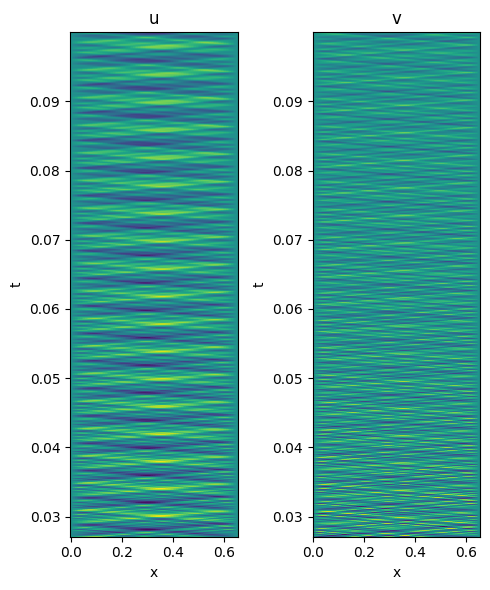

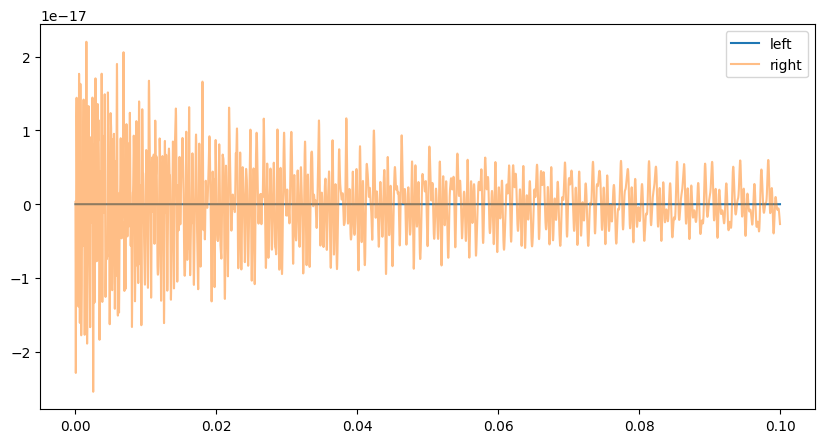

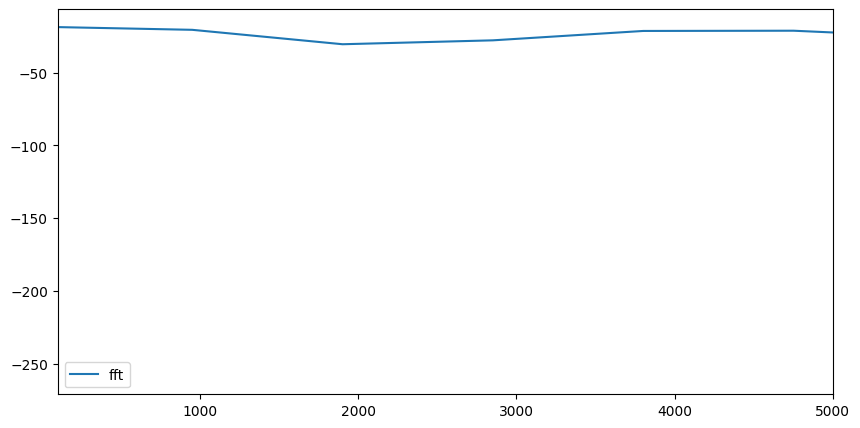

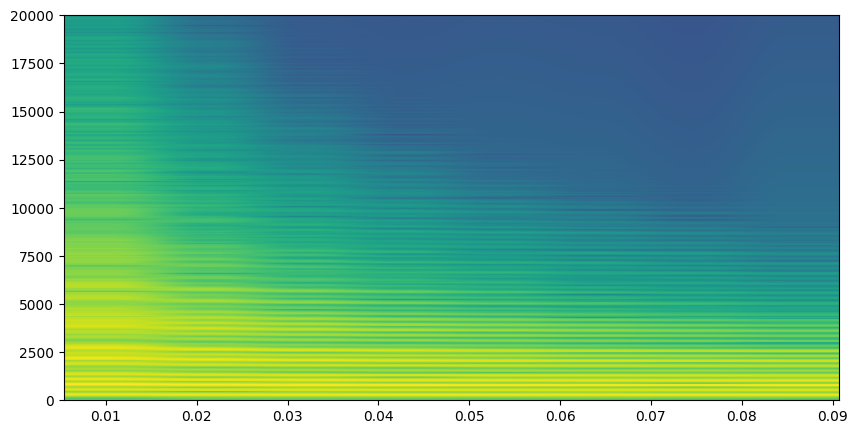

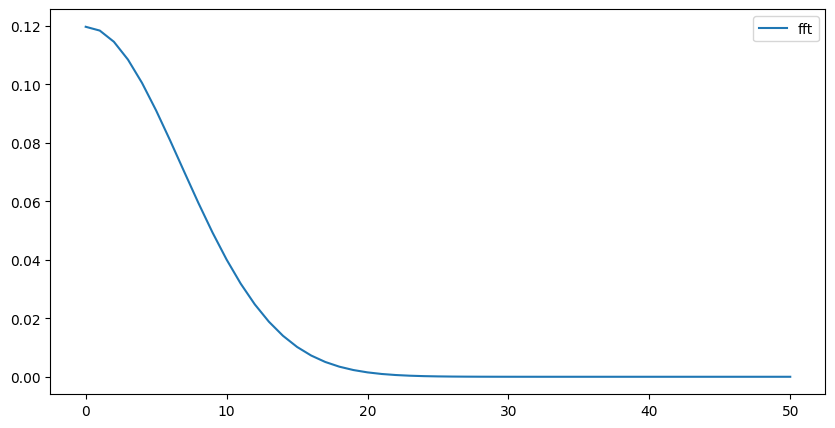

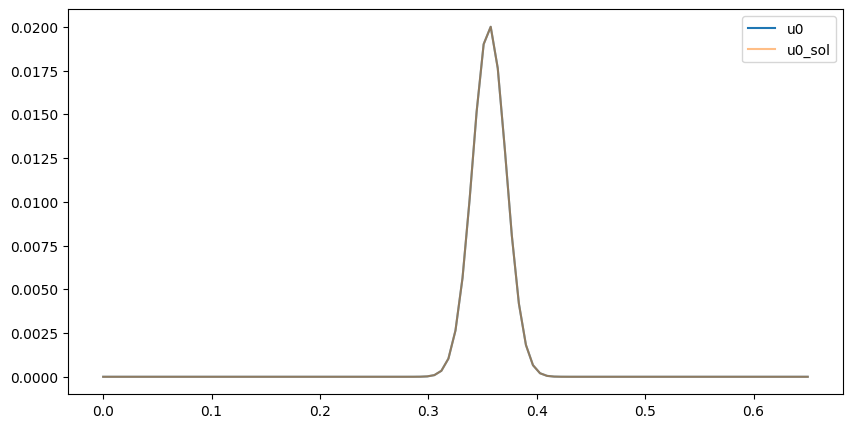

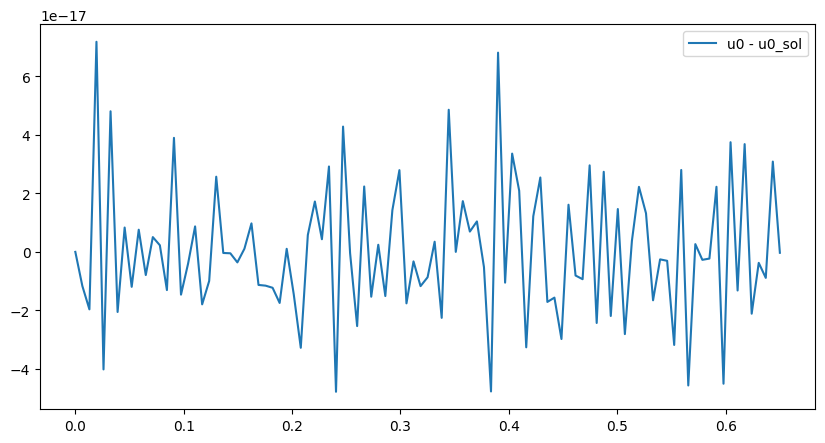

In [ ]:
# | eval: false

n_samples_plot = 7000
fig, ax = plt.subplots(1, 2, figsize=(5, 6))
ax[0].pcolormesh(solver.grid, t[-n_samples_plot:], u[-n_samples_plot:, :])
ax[0].set_title("u")
ax[0].set_xlabel("x")
ax[0].set_ylabel("t")
ax[1].pcolormesh(solver.grid, t[-n_samples_plot:], v[-n_samples_plot:, :])
ax[1].set_title("v")
ax[1].set_xlabel("x")
ax[1].set_ylabel("t")
fig.tight_layout()
plt.show()
# plot the solution at the endpoints
plt.figure(figsize=(10, 5))
plt.plot(t, u[:, 0], label="left")
plt.plot(t, u[:, -1], label="right", alpha=0.5)
plt.legend()
plt.show()

# Plot FFT of the solution for a point on the string, in db scale
plt.figure(figsize=(10, 5))
freq = np.fft.rfftfreq(u.shape[-1], d=solver.dt)
plt.plot(freq, 20 * np.log10(np.abs(np.fft.rfft(u[17, :]))), label="fft")
# plt.figure(figsize=(10, 5))
# freq = np.fft.rfftfreq(u.shape[0], d=solver.dt)
# plt.plot(freq, np.abs(np.fft.rfft(u[:, 17])), label="fft")
# plt.xlim(3000, 8000)
plt.xlim(100, 5000)
plt.legend()
plt.show()

# Plot spectrogram of the solution for a point on the string
plt.figure(figsize=(10, 5))
plt.specgram(u[:, 17], Fs=solver.sampling_rate, NFFT=2048, noverlap=1024)
plt.ylim(0, 20000)
plt.show()

# Plot FFT of the initial condition
plt.figure(figsize=(10, 5))
freq = np.fft.rfftfreq(u.shape[-1], d=solver.dx)
# plt.plot(freq, np.abs(np.fft.rfft(u0)), label="fft")
plt.plot(np.abs(np.fft.rfft(u0)), label="fft")
# plt.xlim(0, 1)
plt.legend()

# plot the initial conditions
plt.figure(figsize=(10, 5))
plt.plot(solver.grid, u0, label="u0")
plt.plot(solver.grid, u[0, :], label="u0_sol", alpha=0.5)
plt.legend()
plt.show()

# Plot the difference between the initial condition given and the one obtained from the solution
plt.figure(figsize=(10, 5))
plt.plot(solver.grid, u0 - u[0], label="u0 - u0_sol")
plt.legend()
plt.show()

In [ ]:
# | eval: false

from IPython import display as ipd

In [ ]:
# | eval: false

# Play the solution as audio
ipd.Audio(u[:, 27], rate=solver.sampling_rate)